# More simulation: Fitting to multiple simple step protocols

We now look at the problem of fitting to multiple voltage-step protocols (without ramps or sine waves).

For this we'll use four protocols, based on conventional protocols for IKr, that were used in ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://physoc.onlinelibrary.wiley.com/doi/full/10.1113/JP275733). 
The protocol files used here are from [the repository for "Four ways to fit an ion channel model"](https://github.com/CardiacModelling/FourWaysOfFitting).

In [1]:
protocol_files = [
    'resources/pr2-activation-kinetics-2.mmt',
    'resources/pr3-steady-activation.mmt',
    'resources/pr4-inactivation.mmt',
    'resources/pr5-deactivation.mmt',
]

We begin by creating another [pints.ForwardModel](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model), this time one that takes a protocol as one of its constructor arguments:

In [2]:
import matplotlib.pyplot as plt
import myokit
import myokit.lib.hh
import numpy as np
import pints

class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        
        # Isolate a Hodgkin-Huxley model
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)
        
        # Create an analytical simulation
        self.sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        
        # Get a maximum simulation time        
        tmax = times[-1] + 0.1
        
        # Reset the simulation
        self.sim.reset()
        
        # Apply the new parameters
        self.sim.set_parameters(parameters)
        
        # Run the simulation
        log = self.sim.run(tmax, log_times=times)
        
        # Return the calculated currents
        return log['ikr.IKr']
        

We can test this class by running a simulation on one of the protocols:

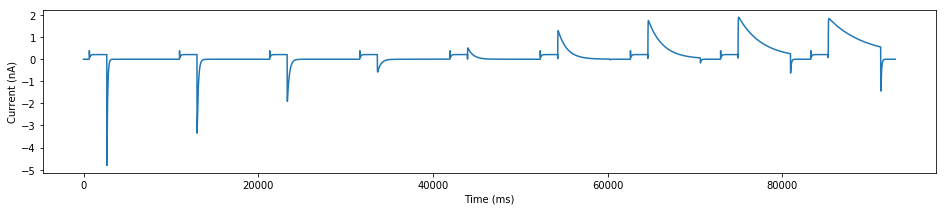

In [3]:
# Load a protocol
protocol = myokit.load_protocol(protocol_files[3])

# Create a forward model instance
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Select times to evaluate at
times = np.arange(0, protocol.characteristic_time(), 0.1)

# Simulate and plot
plt.figure(figsize=(16, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, model.simulate(parameters, times))
plt.show()

As before, we can add some synthetic data:

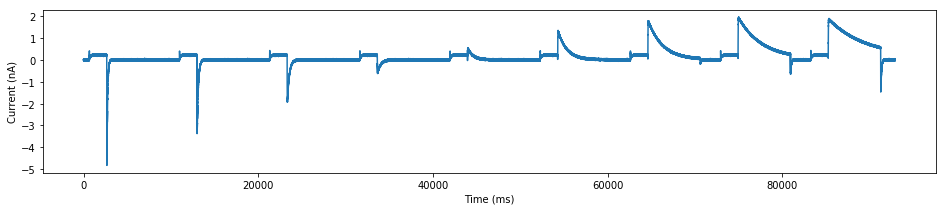

In [4]:
plt.figure(figsize=(16, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, model.simulate(parameters, times) + np.random.normal(0, 0.015, len(times)))
plt.show()

We now repeat this trick four times, setting up four [problems](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem) and defining four [error measures](https://pints.readthedocs.io/en/latest/error_measures.html):

In [9]:
# Define a "true" parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Create lists of problems and error measures
problems = []
errors = []

for protocol_file in protocol_files:
    # Load a protocol
    protocol = myokit.load_protocol(protocol_file)

    # Create a forward model instance
    model = Model(protocol)

    # Select times to evaluate at
    times = np.arange(0, protocol.characteristic_time(), 0.1)
    
    # Create synthetic noisy data
    values = model.simulate(parameters, times)
    values += np.random.normal(0, 0.015, len(times))
    
    # Create a pints Problem and ErrorMeasure
    problem = pints.SingleOutputProblem(model, times, values)
    error = pints.MeanSquaredError(problem)
    
    # Store the problems and errors in arrays
    problems.append(problem)
    errors.append(error)


Now we've got four different error functions that we can try solving.
Alternatively, we can sum all the errors together using a [pints.SumOfErrors](https://pints.readthedocs.io/en/latest/error_measures.html#pints.SumOfErrors):

In [7]:
error = pints.SumOfErrors(errors)

We've now combined our four simulations into a single error function, that we can evaluate on any parameter set:

In [8]:
print(error(parameters))
print(error(parameters * 2))

0.0008995121315455267
1.7899747922882498


## But what about weighting?

In the above code, we summed four errors together, giving them all equal weight.
But we never checked whether the errors have comparable scales, so this was probably a bad idea!

Let's have a look at the individual problems first.
We'll plot the noisy data so we don't need to run any simulations:

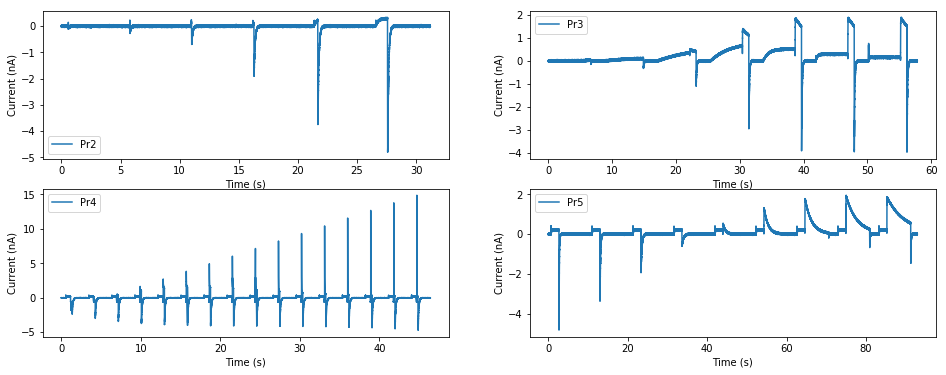

In [13]:
plt.figure(figsize=(16, 6))

for i, problem in enumerate(problems):
    plt.subplot(2, 2, 1 + i)
    plt.xlabel('Time (s)')
    plt.ylabel('Current (nA)')
    plt.plot(problem.times() / 1000, problem.values(), label='Pr' + str(2 + i))
    plt.legend()

plt.show()

Note that these protocols are a lot longer than the ones we used previously (and we've changed the x-axis units from ms to s).
Two things immediatly stand out with respect to defining an error:

- The protocols all have a different length
- The protocols all elicit currents of different sizes. In particular, the currents from protocol "Pr4" has a range of approximately 20nA, while the currents from the remaining protocols seem to lie in a 5nA range.

Now let's look at the error we defined on each problem.
We used [mean squared errors](https://pints.readthedocs.io/en/latest/error_measures.html#pints.MeanSquaredError), which the documentation shows us are defined as:

$$ f = \frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2 $$

where $N$ is the number of samples, and $x$ and $y$ are the two signals being compared.

The division by $N$ looks like it will take care of the different lenght of the protocols.
But the problem of different current magnitudes isn't addressed.
If anything, it's made worse by squaring the error.
To remedy the effect of squaring, we can use a [root-mean-squared-error](https://pints.readthedocs.io/en/latest/error_measures.html#pints.RootMeanSquaredError) (as was done in the ["Four ways of fitting"](https://www.cell.com/biophysj/fulltext/S0006-3495(19)30666-6) paper):

$$ f = \sqrt{ \frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2 } $$

This looks better, although you could argue that the squaring still causes the error measure to overemphasise large errors, so that a [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) may be more appropriate.

So, having decided that the error measure is OK, and already compensates for the different lengths of the protocols, we turn back to the problem of the different current magnitudes.
One possible strategy to address this is to define a scaling factor, or _weight_ for each protocol, based on the maximum and minimum current in the experimental data.
For a protocol $j$, with experimental data $I_j$, we set:

$$ w_j = \frac{1}{(\max I_j - \min I_j)} $$

We now revisit the code above, using root-mean-squared errors and weights:

In [14]:
# Define new errors and weights
errors = []
weights = []
for problem in problems:
    
    # Calculate a weight
    weight = 1 / (np.max(problem.values()) - np.min(problem.values()))
    weights.append(weight)
    
    # Define a root mean squared error
    error = pints.RootMeanSquaredError(problem)
    errors.append(error)

# Create a root mean squared error
error = pints.SumOfErrors(errors, weights)

This gives us an error measure we can minimise in order to fit to all four protocols simultaneously.

## Other options, and multi-objective optimisation

We've now developed a method to optimise to multiple protocols.
But is it the best method?

If we assume that the model is able to fit the data well, and that the experiments were performed under exactly the same conditions, then it should be possible to find a single parameter set that produces great fits simultaneously in all four protocols.
Under this assumption, the choice of error function will affect the performance of the optimiser, but won't matter too much for the final result as long as the error function is zero at the "true" parameters.



But what if we don't make this assumption?
For example, we could regard the model as something that is (necessarily?) slightly wrong, or maybe we doubt that experimental conditions can be kept steady enough to provide a consistent set of experiments.
With this way of thinking, we might regard the four error measures as representing conflicting objectives.
The field of [multi-objective optimisation](https://en.wikipedia.org/wiki/Multi-objective_optimization) deals with such scenarios.
Thining along these lines, it becomes tempting to choose protocols, or even parts of protocols, that are more important to us than other, and to assign these extra weight.




Whether or not this is a good idea is up for debate!

## Summary

In this part of the tutorial,

- we created a ForwardModel implementation that worked on multiple protocols
- created four instances of this model, and defined four error measures on synthetic data
- combined these errors into a single error using a SumOfErrors
- looked at different ways to weight the errors

In the next part of the tutorial we'll look at ways to define boundaries on the model parameters.